In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance
import sys
import matplotlib.pyplot as plt
from itertools import combinations

## Load word embeddings of pretrained Glove model

In [2]:
# progress bar
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush() 

# load dictionary of word vectors based on pretrained Glove model
def loadGloveDict(File):
    print("Loading glove model")
    f = open(File, 'r', encoding = 'utf-8')
    gloveDict = {}
    i = 0
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        progress(i, 400000, status = 'retreiving vectors')
        wordEmbedding = pd.DataFrame([float(value) for value in splitLine[1:]]).T
        gloveDict[word] = wordEmbedding
        i += 1
    print(len(gloveDict), "words loaded")
    return gloveDict

In [3]:
#model = loadGloveDict("../glove.6B/glove.6B.300d.txt")

Loading glove model
400000 words loaded==========================================] 100.0% ...retreiving vectors


In [4]:
# get vectors for extracted features
features = pd.read_csv("finalFeatures.csv", usecols = ['index'])
numFeatures = len(features['index'])
vectorlist = []
notInCorpus = []

for i in range(0, numFeatures):
    progress(i, numFeatures - 1, status = "concatenating extracted vectors")
    wordAsDF = features['index'][[i]]
    try:
        vector = pd.concat([wordAsDF, model[wordAsDF[i]].set_index(wordAsDF.index)], axis = 1)
        vectorlist.append(vector)
    except KeyError:
        notInCorpus.append(wordAsDF[i])

embeddings = pd.concat(vectorlist).reset_index(drop = True).rename(columns = {"index":"feature"})
embeddings

,feature,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,staff,-0.119230,0.543580,0.038506,-0.319690,-0.377030,-0.217890,0.141050,0.021194,-0.062184,...,0.005292,-0.600760,-0.638920,-0.318530,-0.312020,-0.000710,-0.593350,-0.278180,-0.167850,-0.526690
1,people,-0.413550,0.076012,0.099178,-0.011950,0.018657,0.050379,-0.036780,0.450220,0.039699,...,0.029591,-0.911070,0.063804,-0.361780,0.284970,-0.137340,-0.295770,0.159530,-0.132230,0.030910
2,medical,-0.214970,-0.417860,0.196710,-0.048824,0.051670,-0.430020,0.391770,-0.524160,-0.019886,...,-0.011432,-0.327000,-0.246620,-0.557700,-0.289130,-0.270340,0.352470,-0.551930,0.164130,0.150710
3,bad,0.308820,-0.126930,-0.077843,-0.010746,-0.146190,-0.225660,0.075975,0.854470,0.298560,...,0.013942,-0.097010,-0.198380,-0.167870,0.410860,-0.491000,-0.158470,-0.135350,-0.104460,0.232560
4,place,0.080622,0.132080,-0.004764,-0.456130,-0.084077,0.081094,-0.171920,0.241880,0.267370,...,-0.062303,-0.035127,-0.260430,-0.148550,0.200120,0.214640,0.002107,-0.063376,-0.469610,0.405380
5,rude,0.050660,-0.579060,0.444340,0.157230,-0.583490,-0.033701,-0.131960,0.151220,0.325940,...,0.118640,0.121660,-0.037853,-0.237610,0.790840,-0.359510,-0.274070,0.263380,0.160410,-0.152300
6,time,-0.135440,0.145390,0.098176,0.027927,0.137730,-0.101570,-0.077469,-0.088126,0.337310,...,-0.207410,-0.097232,-0.042869,-0.246580,0.149910,0.040743,-0.184650,-0.072427,-0.330190,0.006131
7,reviews,-0.046538,-0.301090,0.274430,-0.163360,-0.011083,0.351060,0.100580,0.316000,-0.276390,...,0.329270,-0.006374,-0.994270,0.009861,-0.626010,0.417670,-0.253080,0.133610,0.531380,-0.017204
8,service,-0.680510,-0.170790,0.047996,0.414010,0.067018,-0.131610,-0.094423,0.400200,-0.341120,...,0.117080,-0.082069,-0.578670,-0.186030,-0.036372,0.269240,-0.000567,-0.251270,0.110930,-0.540980
9,nsf,0.210070,-0.404900,0.294490,-0.068685,0.134630,0.483380,-0.618080,-0.434090,-0.216970,...,-0.072840,0.076782,-0.413650,0.228260,0.380030,0.162920,-0.202410,0.121950,-0.063990,-0.057609


In [5]:
notInCorpus

['cmpb']

In [ ]:
# visualise word embeddings with tsne models
def tsne_plot(model):
    labels = []
    tokens = []

    i = 0
    for word in model.keys():
        progress(i, len(model.keys()), status = "appending vectors")
        tokens.append(model[word])
        labels.append(word)
        i += 1
    
    print("\nrunning tsne model")
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=0)
    new_values = tsne_model.fit_transform(tokens)
    print("\ntnse modelling complete")

    x = []
    y = []
    j = 0

    for value in new_values:
        progress(j, len(new_values), status = "appending x,y values")
        x.append(value[0])
        y.append(value[1])
        j += 1
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        progress(i, len(new_values), status = "plotting")
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)

## K-means clustering and evaluation

In [6]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(embeddings.iloc[:,1:])
X_train

array([[-0.16199518,  1.95555994,  0.22133067, ..., -0.85167208,
        -0.2395161 , -1.96848999],
       [-1.60569626,  0.27829465,  0.44458862, ...,  0.80398186,
        -0.12804155,  0.06878804],
       [-0.63161988, -1.49332865,  0.80348224, ..., -1.88714137,
         0.79943173,  0.50649591],
       ...,
       [ 0.33207217, -1.66081555,  0.66777297, ...,  1.72525638,
        -1.02315529,  0.89984841],
       [-0.66193407,  0.47511777, -0.86822934, ..., -0.41093095,
         1.04895071, -0.47286631],
       [ 0.34496306,  0.42916559, -0.39022948, ..., -0.59888518,
        -0.48712605,  0.34862148]])

c:\users\tzemin\appdata\local\programs\python\python37\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\users\tzemin\appdata\local\programs\python\python37\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


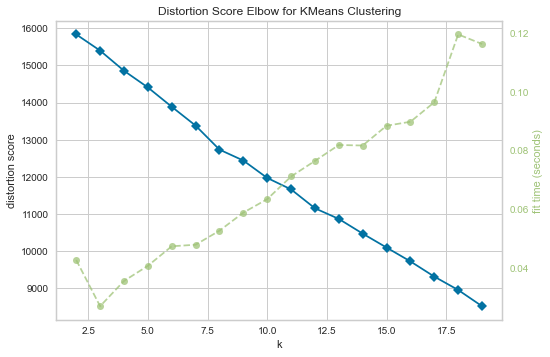

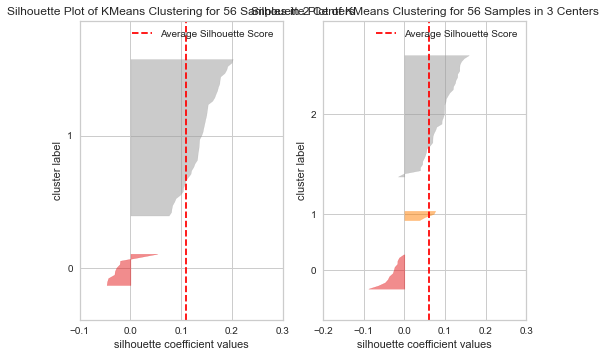

In [7]:
kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (2,20))
visualizer.fit(X_train)
visualizer.poof()

fig, axes = plt.subplots(1, 2)
visualgrids = []
clusters = [2,3]

for i in range(len(clusters)):
    kmeans = KMeans(n_clusters = clusters[i], init = 'k-means++', random_state = 0)
    viz = SilhouetteVisualizer(kmeans, ax=axes[i])
    visualgrids.append(viz)

for viz in visualgrids:
    viz.fit(X_train)
    viz.finalize()

plt.show()

## Finalised model

In [8]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 0)
y = kmeans.fit_predict(X_train)

labels = pd.DataFrame(kmeans.labels_).reset_index(drop=True).rename({0:"label"}, axis = 1)
words = pd.DataFrame(embeddings["feature"]).reset_index(drop=True)
finalfeatures = pd.concat([words, labels], axis = 1)

finalfeatures.head()

,feature,label
0,staff,3
1,people,5
2,medical,7
3,bad,5
4,place,1


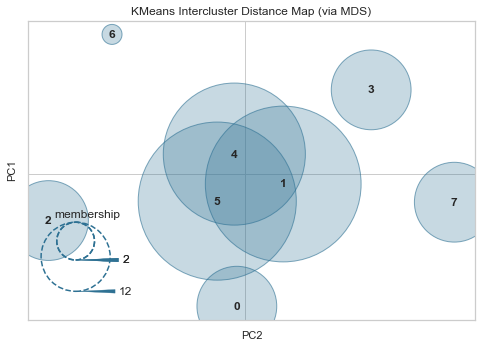

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [9]:
## yellowbrick's interclusterdistance
plt.cla()
viz = InterclusterDistance(kmeans)
viz.fit(X_train)
viz.show()

In [ ]:
# create pairs of nodes, where each word occupies a node
unique_labels = list(finalfeatures['label'].unique())
pairslist = []

for x in unique_labels:
    cluster = finalfeatures.loc[finalfeatures['label'] == x].index 
    combi = pd.DataFrame(combinations(cluster, 2))
    pairslist.append(combi)

pairs = pd.concat(pairslist).reset_index(drop=True)
pairs.columns = ['node1', 'node2']
pairs.head()

# add weights to each edge between nodes -- what should determine the weights?
